# Boxplot of DE junctions

In [1]:
library(ggpubr)
library(ggplot2)
library(tidyverse)
suppressMessages(library(data.table))

Loading required package: ggplot2

-- Attaching packages ----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- tidyverse 1.3.1 --

v tibble  3.1.2     v dplyr   1.0.7
v tidyr   1.1.3     v stringr 1.4.0
v readr   1.4.0     v forcats 0.5.1
v purrr   0.3.4     

-- Conflicts -------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()



In [2]:
ggplot_save <- function(p, fn, w=7, h=7){
    for(ext in c('.svg', '.png', '.pdf')){
        ggsave(p, filename=paste0(fn, ext), width=w, height=h)
    }
}


subset_deg <- function(fn, thres){
    jt = fread(fn) %>% rename(Feature='V1') %>% 
        filter(adj.P.Val < thres) %>% 
        select(Feature, ensemblID, Symbol, logFC, adj.P.Val)
    return(jt)
}


add_symnum <- function(res){
    symnum.args <- list(cutpoints = c(0, 0.0001, 0.001, 0.01, 0.05,  1),
                        symbols = c("****", "***", "**", "*",  "ns"))
    symnum.args$x <- res$adj.P.Val
    pvalue.signif <- do.call(stats::symnum, symnum.args) %>%
        as.character()
    pvalue.format <- format.pval(res$adj.P.Val, digits = 2)
    res <- res %>%
        dplyr::ungroup() %>%
        mutate(FDR = pvalue.format, p.signif = pvalue.signif)
    return(res)
}


## Load DEG annotation

In [3]:
fn1 = '../../_m/junctions/diffExpr_interaction_full.txt'
fn2 = '../../_m/junctions/diffExpr_maleVfemale_full.txt'
fn3 = '../../_m/junctions/diffExpr_szVctl_full.txt'
juncs = subset_deg(fn1, 0.05)
sex = subset_deg(fn2, 1)
sz = subset_deg(fn3, 1)

In [4]:
df = juncs %>% 
        inner_join(sex, by=c("Feature", "ensemblID", "Symbol"), suffix=c('', "_Sex")) %>%
        inner_join(sz, by=c("Feature", "ensemblID", "Symbol"), suffix=c('', "_Diagnosis"))
df = add_symnum(df)
df

Feature,ensemblID,Symbol,logFC,adj.P.Val,logFC_Sex,adj.P.Val_Sex,logFC_Diagnosis,adj.P.Val_Diagnosis,FDR,p.signif
<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
chr18:31592940-31592993(+),,,3.982802,0.005745959,-1.6752336,1.716723e-02,-2.1958914,0.2215927424,0.0057,**
chrX:140784309-140784456(+),,,3.240533,0.034981821,-1.0434140,3.526305e-01,-2.3321288,0.1212491463,0.0350,*
chr21:8219273-8402302(-),,,-3.091047,0.034981821,1.7599218,9.804002e-06,2.0058671,0.1908706827,0.0350,*
chr6:31816438-31828631(+),,,-3.978074,0.034981821,1.2654325,5.413912e-01,3.6998481,0.0042981080,0.0350,*
chr10:17881182-17885268(+),ENSG00000260314,MRC1,-1.087409,0.034981821,0.2701876,6.248149e-01,0.9202482,0.0320243060,0.0350,*
chr21:8401646-8443413(-),,,-3.519362,0.034981821,1.8674934,5.725948e-02,3.7184872,0.0002316139,0.0350,*


## Load phenotypes

In [12]:
pheno_file = '/ceph/projects/v3_phase3_paper/inputs/phenotypes/_m/hippo_phenotypes.csv'
pheno = fread(pheno_file) %>% column_to_rownames(var='V1') %>% 
    mutate_if(is.character, as.factor)
levels(pheno$Sex) <- c("Female", "Male")
levels(pheno$Dx) <- c("CTL", "SZ")
pheno %>% head(2)

,BrNum,RNum,Region,RIN,Age,Sex,Race,Dx
,<fct>,<fct>,<fct>,<dbl>,<dbl>,<fct>,<fct>,<fct>
R11135,Br2063,R11135,HIPPO,5.9,18.77,Male,CAUC,CTL
R11137,Br2582,R11137,HIPPO,9.2,41.44,Male,CAUC,CTL


## Load residualized expression

In [13]:
res_file = '../../_m/junctions/residualized_expression.tsv'
resdf = fread(res_file) %>% 
    column_to_rownames(var="V1") %>% t
resdf = as.data.frame(resdf) %>% 
    rownames_to_column() %>% 
    rename(RNum=rowname) %>% 
    select(RNum, df$Feature)
resdf[1:2, 1:3]

Warning message in fread(res_file):
"Detected 375 column names but the data has 376 columns (i.e. invalid file). Added 1 extra default column name for the first column which is guessed to be row names or an index. Use setnames() afterwards if this guess is not correct, or fix the file write command that created the file to create a valid file."


,RNum,chr18:31592940-31592993(+),chrX:140784309-140784456(+)
,<chr>,<dbl>,<dbl>
1,R11135,-0.09911295,-1.422550
2,R11137,1.40998077,-0.778713


## Merge data

In [14]:
jj = pheno %>% 
    inner_join(resdf, by='RNum')
jj$Dx = fct_drop(jj$Dx)
jj %>% dim
jj[1:2, 1:10]

[1] 375  14

,BrNum,RNum,Region,RIN,Age,Sex,Race,Dx,chr18:31592940-31592993(+),chrX:140784309-140784456(+)
,<fct>,<chr>,<fct>,<dbl>,<dbl>,<fct>,<fct>,<fct>,<dbl>,<dbl>
1,Br2063,R11135,HIPPO,5.9,18.77,Male,CAUC,CTL,-0.09911295,-1.422550
2,Br2582,R11137,HIPPO,9.2,41.44,Male,CAUC,CTL,1.40998077,-0.778713


In [15]:
dft = jj %>% pivot_longer(-c(BrNum, RNum, Region, RIN, Age, Sex, Race, Dx), 
                          names_to="Feature", values_to="Res") %>% 
    inner_join(df, by="Feature") %>% mutate_at("Feature", as.factor)
dft[1:2, 1:10]

BrNum,RNum,Region,RIN,Age,Sex,Race,Dx,Feature,Res
<fct>,<chr>,<fct>,<dbl>,<dbl>,<fct>,<fct>,<fct>,<fct>,<dbl>
Br2063,R11135,HIPPO,5.9,18.77,Male,CAUC,CTL,chr18:31592940-31592993(+),-0.09911295
Br2063,R11135,HIPPO,5.9,18.77,Male,CAUC,CTL,chrX:140784309-140784456(+),-1.42254965


Warning message:
"Ignoring unknown aesthetics: xmin, xmax, annotations, y_position"


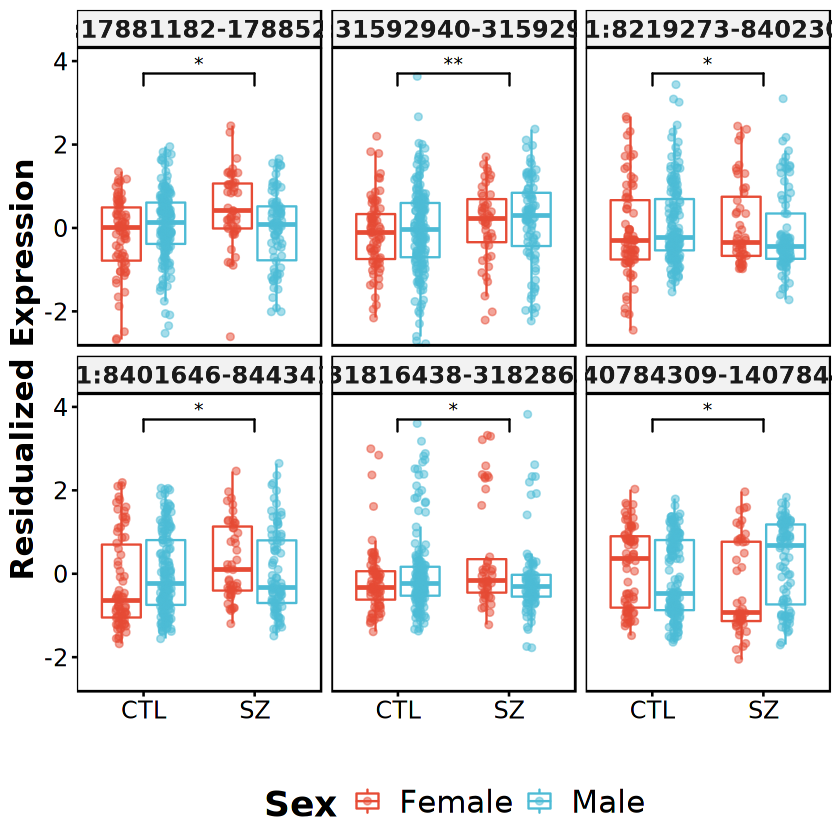

In [20]:
tmp = df %>% mutate(group1='CTL', group2='SZ', y_pos=3.7)

bxp <- ggboxplot(dft, x="Dx", y="Res", color="Sex", add='jitter',
                 panel.labs.font=list(face='bold', size = 14),
                 facet.by=c("Feature"), palette="npg", xlab='', 
                 ylim=c(-2.5, 4), ylab='Residualized Expression', 
                 add.params=list(alpha=0.5), legend="bottom", 
                 outlier.shape=NA) +
        geom_signif(data=tmp, 
                    aes(xmin=group1, xmax=group2, 
                        annotations=p.signif, y_position=y_pos), 
                    manual=TRUE) + 
        font("xy.title", size=18, face="bold") + font("xy.text", size=14) + 
        font("legend.title", size=21, face="bold") + font("legend.text", size=18)
         
bxp

In [22]:
ggplot_save(bxp, 'junc_interaction', 10, 8)

## Session Info

In [ ]:
Sys.time()
proc.time()
options(width = 120)
sessioninfo::session_info()